In [142]:
import keras
import cv2
import glob
import matplotlib.pyplot as plt 
import numpy as np
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
x = glob.glob('LaptopController/GroundFloor5/*')[2]

In [163]:
finalset = []
new_size_row = 128
new_size_col = 84

In [164]:
for x in glob.glob('LaptopController/GroundFloor?/*'):
    jpg_index = x.find('.jpg')
    first_index = x.find('--')+3
    last_index = x.find('--',first_index) + 2
    speed = x[last_index:jpg_index]
    if speed == 's1':
        angle = x[first_index:last_index-2]
        finalset.append(x)

In [165]:
len(finalset)

8166

In [97]:
img = cv2.imread(finalset[15])
rows,cols, _ = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1.4)
dst = cv2.warpAffine(img,M,(cols,rows))

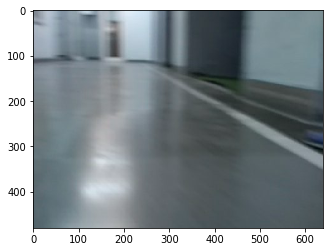

In [98]:
plt.imshow(dst)
plt.show()

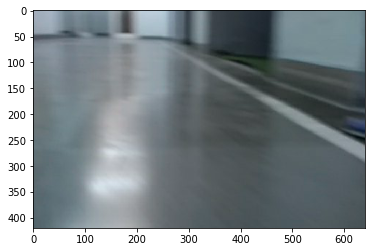

In [110]:
crop_img = dst[59:-1, :]
plt.imshow(crop_img)
plt.show()

In [111]:
crop_img.shape

(420, 640, 3)

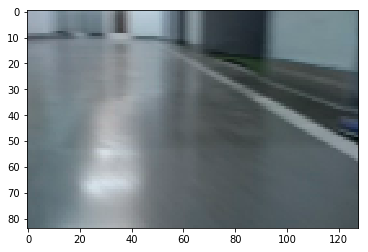

In [113]:
x = cv2.resize(crop_img,(128,84))
plt.imshow(x)
plt.show()

In [158]:
def preprocess(img):
    rows,cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1.4)
    dst = cv2.warpAffine(img,M,(cols,rows), cv2.INTER_AREA)
    crop_img = dst[59:-1, :]
    x = cv2.resize(crop_img,(128,84))
    return x
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
def add_random_shadow(image):
    top_y = 128*np.random.uniform()
    top_x = 0
    bot_x = 84
    bot_y = 128*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image
def preprocess_image_file_train(line_data):
    image = cv2.imread(line_data)
    
    #finding angle
    jpg_index = line_data.find('.jpg')
    first_index = line_data.find('--')+3
    last_index = line_data.find('--',first_index) + 2
    y_steer = float(line_data[first_index:last_index-2])
    
    
    image = augment_brightness_camera_images(image)
    image = preprocess(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image, y_steer

def generate_train_from_PD_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, 84, 128, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        a=0
        while a < batch_size-1:
            i_line = np.random.randint(len(data))
            line_data = data[i_line]
            
            x,y = preprocess_image_file_train(line_data)
        
            if(not (y<-0.1 or y > 0.1)):
                if np.random.random_sample() < 0.7:
                    continue
                else:
                    a = a + 1
            else:
                a = a + 1
            batch_images[a]= x
            batch_steering[a] = y
#         for i_batch in range(batch_size):
#             i_line = np.random.randint(len(data))
#             line_data = data[i_line]
#             keep_pr = 0
#             #x,y = preprocess_image_file_train(line_data)
#             x,y = preprocess_image_file_train(line_data)
#             #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
#             #y = np.array([[y]])
#             if(not (y<-0.1 or y > 0.1):
#                 if(np.random.randint(1)==1):
#                    i_batch
#             batch_images[i_batch] = x
#             batch_steering[i_batch] = y
#             figure()
#             plt.imshow(x)
#             plt.imshow()
        yield batch_images, batch_steering

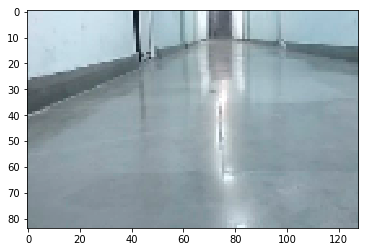

0.0


In [128]:
i_line = np.random.randint(len(finalset))
line_data = finalset[i_line]
x,y = preprocess_image_file_train(line_data)
plt.imshow(x)
plt.show()
print(y)

In [160]:
model = models.Sequential()
model.add(convolutional.Convolution2D(16, 3, 3, input_shape=(84, 128, 3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
model.add(convolutional.Convolution2D(16, 3, 3, activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
model.add(convolutional.Convolution2D(32, 3, 3, activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.5))
model.add(core.Flatten())
model.add(core.Dense(500, activation='relu'))
model.add(core.Dropout(.5))
model.add(core.Dense(100, activation='relu'))
model.add(core.Dropout(.25))
model.add(core.Dense(20, activation='relu'))
model.add(core.Dense(1))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam')

/home/sid/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(84, 128, ...)`
  
/home/sid/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  after removing the cwd from sys.path.
/home/sid/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), activation="relu")`
  


In [161]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 82, 126, 16)       448       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 41, 63, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 39, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 19, 30, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 17, 28, 48)        13872     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 4, 7, 48)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 7, 48)          0         
__________

In [162]:
model.fit_generator(generate_train_from_PD_batch(finalset,32),samples_per_epoch=500,verbose=1)

/home/sid/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=500, verbose=1)`
  """Entry point for launching an IPython kernel.


Epoch 1/1
500/500 [==============================] - 1139s - loss: 10.4492  
